# Ice multithermal with OPES
for reference

In [1]:
import numpy as np
import mdtraj as md

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import openmm, openmm.app
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [3]:
from rigid_flows.systems.watermodel import WaterModel, plot_energy

## Initialize system

In [4]:
#some options

temp = 150
water_type = 'tip4pew'
ice_type = 'XI'
rep = 3*[1]

nonbondedCutoff = 1
rigidWater = True
external_field = None

In [ ]:
### setup the model
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule
from tempfile import NamedTemporaryFile

gro = GenIce(Lattice(ice_type), rep=rep).generate_ice(Format('gromacs'), water=Molecule('tip4p'))
tmp = NamedTemporaryFile()
with open(tmp.name, 'w') as f:
    f.write(gro)
config = openmm.app.GromacsGroFile(tmp.name)

pos = np.array(config.getPositions().value_in_unit(unit.nanometer))
box = np.array(config.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
model = WaterModel(
    positions=pos,
    box=box,
    water_type=water_type,
    nonbondedCutoff=nonbondedCutoff,
    rigidWater=rigidWater,
    external_field=external_field,
)

print('n_waters:', model.n_molecules)
print('orthorombic:', model.is_box_orthorombic)
print(f'nonbondedCutoff: {model.nonbondedCutoff} ({model.nonbondedCutoff/0.316435:g} [sigmaLJ])') #3.16 is common, 2.5 is ok, below 1.14 is very bad

if model.is_box_orthorombic:
    toPBC = True
else:
    toPBC = False
model.plot_2Dview(toPBC=toPBC)
model.get_view()

In [6]:
model.system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f00d1efe8e0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f00d1effd20> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f00d1effed0> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7f00d1effb70> >]

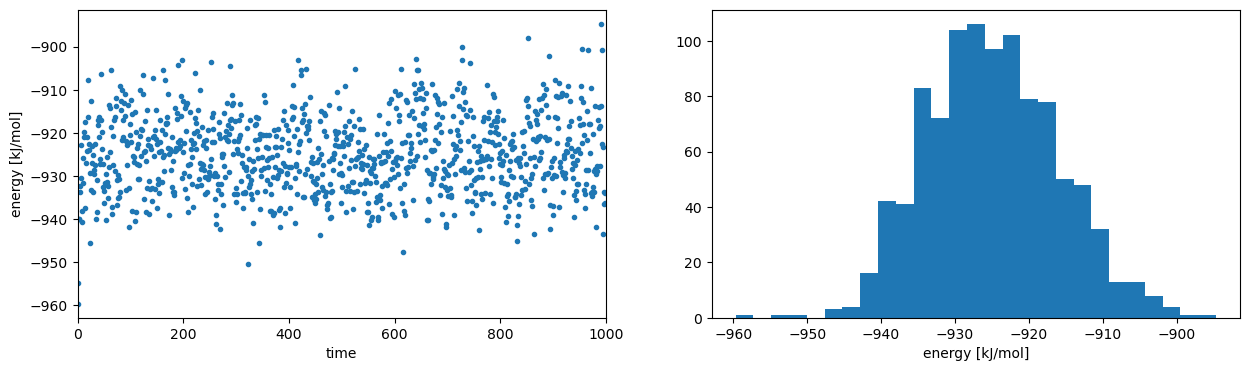

CPU times: user 57.2 s, sys: 1.28 s, total: 58.5 s
Wall time: 57.1 s


In [7]:
%%time
#Equilibrate

model.set_barostat = None
print('barostat:', model.barostat)

pace = 500
n_iter = 1_000
simulation = model.setup_simulation(temp, minimizeEnergy=True)

MDene = np.full(n_iter, np.nan)
MDpos = np.full((n_iter, *model.positions.shape), np.nan)
if model.barostat is None:
    MDbox = np.resize(model.box, (1,3,3))
else:
    MDbox = np.full((n_iter, 3, 3), np.nan)

for n in range(n_iter):
    simulation.step(pace)
    MDene[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    MDpos[n] = simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(asNumpy=True).value_in_unit(unit.nanometers)
    if model.barostat is not None:
        MDbox[n] = simulation.context.getState().getPeriodicBoxVectors(asNumpy=True).value_in_unit(unit.nanometers)
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_energy(MDene[:n+1])
    print(f'sampling...  {n/n_iter:.2%}', end='\r')

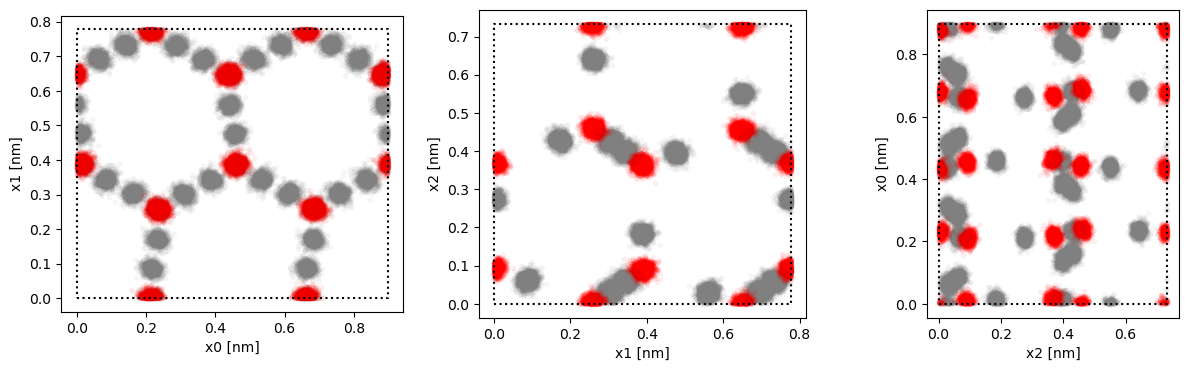

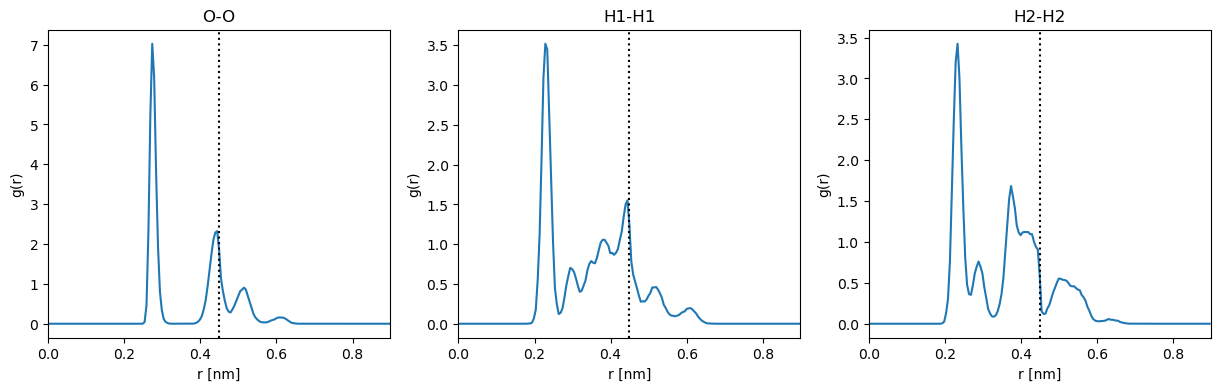

In [8]:
model.plot_2Dview(MDpos, MDbox, toPBC=toPBC)

#plot rdf
r_range = [0, model.box.max()]
names = ['O', 'H1', 'H2']
n = 1
plt.figure(figsize=(5*len(names), 4))
for a in names:
    plt.subplot(1, len(names), n)
    
    plt.title(f'{a}-{a}')
    model.plot_rdf(MDpos, r_range=r_range, selection=f'name == {a}')
    plt.axvline(model.box.max()/2, ls=':', c='k')
    n += 1   
plt.show()

# model.get_view(MDpos, MDbox)

In [11]:
#set reference model
model.positions = MDpos[-1]
model.box = MDbox[-1]
ref_model = WaterModel(**model.init_info)
ref_model.system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f00b82c0a80> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f00b837d9b0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f00b837e790> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7f00b837e730> >]

## setup OPES

In [12]:
Tmin = 100
Tmax = 250
temp_steps = 5

In [13]:
%%time

#initialize useful variables
beta = 1/temp/kB
temperatures = np.geomspace(Tmin, Tmax, temp_steps) 
df_size = temp_steps
running_df = np.zeros(temp_steps)
rct = 0
counter = 1

#setup things for MD run
pace = 500
model = WaterModel(**ref_model.init_info)
simulation = model.setup_simulation(temp)

#equilibrate the system and intialize the DeltaFs
n_equil = 500
print('equilibration...', end='\r')
# simulation.minimizeEnergy()
simulation.step(pace*n_equil)
ener = np.zeros(n_equil)
for n in range(n_equil):
    simulation.step(pace)
    ener[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    print(f'sampling...  {(n+1)/n_equil:.1%}', end='\r')
mean_ener = np.mean(ener)
for i in range(df_size):
    running_df[i] = (temp/temperatures[i]-1) * mean_ener

equil_pos = simulation.context.getState(getPositions=True).getPositions()

#print some info
with np.printoptions(precision=2):
    print('Temperatures:', temperatures)
    # print('Initial DeltaFs:', running_df)
print('Mean energy:', mean_ener)
print()

Temperatures: [100.   125.74 158.11 198.82 250.  ]
Mean energy: -924.6520716775449

CPU times: user 52.6 s, sys: 331 ms, total: 52.9 s
Wall time: 52.6 s


In [14]:
# setup biased model using CustomCVForce
import copy

# model = WaterModel(**ref_model.init_info)
robust_bias = False #slower, set True only if the bias becomes nan at beginning of simulation

if isinstance(model.system.getForces()[-1], openmm.CMMotionRemover):
    num_forces = model.system.getNumForces()-1
else:
    assert False, 'last force was supposed to be the CMMotionRemover'

# define bias
ene_str = '('+'+'.join([f'u{k}' for k in range(num_forces)])+')'
if not robust_bias:
    bias_str = '-1/beta*log((0'
    for i in range(df_size):
        bias_str += f'+exp(beta*((1-temp/{temperatures[i]})*{ene_str}+df{i}))'
    bias_str += f')/{df_size}); beta={beta}; temp={temp}'
else:
    # use LogSumExp for stability, but much slower
    bias_str = f'-1/beta*(diffMax+log(1/{df_size}*(0' #this is with LogSumExp
    for i in range(df_size):
        bias_str += f'+exp(diff{i}-diffMax)'
    bias_str += f'))); diffMax=max(diff0,diffMax1)'
    for i in range(1, df_size-2):
        bias_str += f'; diffMax{i}=max(diff{i},diffMax{i+1})'
    bias_str += f'; diffMax{df_size-2}=max(diff{df_size-2},diff{df_size-1})'
    for i in range(df_size):
        bias_str += f'; diff{i}=beta*((1-temp/{temperatures[i]})*{ene_str}+df{i})'
    bias_str += f'; beta={beta}; temp={temp}'
print('Bias potential:', bias_str)

# add bias to forces
bias_potential = openmm.CustomCVForce(bias_str)
for i in range(df_size):
    bias_potential.addGlobalParameter(f'df{i}', running_df[i])
ener_group = 0
bias_group = 1
for k in range(num_forces):
    model.system.getForce(k).setForceGroup(ener_group)
    bias_potential.addCollectiveVariable(f'u{k}', copy.deepcopy(model.system.getForces()[k]))
model.system.addForce(bias_potential)
model.system.getForce(model.system.getNumForces()-1).setForceGroup(bias_group)

model.system.getForces()

Bias potential: -1/beta*log((0+exp(beta*((1-temp/100.0)*(u0+u1+u2)+df0))+exp(beta*((1-temp/125.74334296829353)*(u0+u1+u2)+df1))+exp(beta*((1-temp/158.11388300841895)*(u0+u1+u2)+df2))+exp(beta*((1-temp/198.81768219176263)*(u0+u1+u2)+df3))+exp(beta*((1-temp/250.0)*(u0+u1+u2)+df4)))/5); beta=0.8018157002848403; temp=150


[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f00c944c4e0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f00b837d800> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f00b837e520> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7f00b837fba0> >,
 <openmm.openmm.CustomCVForce; proxy of <Swig Object of type 'OpenMM::CustomCVForce *' at 0x7f00c93b27c0> >]

## run OPES

In [15]:
%%time
# OPES biased MD run

n_iter = 20_000
simulation.context.reinitialize()
simulation.context.setPositions(equil_pos)

data = np.full((n_iter, *model.positions.shape), np.nan)
ener = np.full(n_iter, np.nan) # needed for reweighting
bias = np.full(n_iter, np.nan) # needed for reweighting
all_df = np.full((n_iter, len(running_df)), np.nan)
all_rct = np.full(n_iter, np.nan)

for n in range(n_iter):
    simulation.step(pace)
    data[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    ener[n] = simulation.context.getState(getEnergy=True, groups={ener_group}).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    bias[n] = simulation.context.getState(getEnergy=True, groups={bias_group}).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    ##### update DeltaFs
    increment = 1/beta*np.log1p(np.exp(beta*(bias[n]-rct))/counter)
    for i in range(df_size):
        diff_i = beta*((1-temp/temperatures[i])*ener[n]+bias[n]-rct+running_df[i])
        running_df[i] += increment - 1/beta*np.log1p(np.exp(diff_i)/counter)
        simulation.context.setParameter(f'df{i}', running_df[i])
    counter += 1
    rct += increment + 1/beta*np.log1p(-1/counter)
    ##### 
    all_df[n] = running_df
    all_rct[n] = rct
    # print info
    if (n+1) % 1000 == 0:
        clear_output(wait=True)
        plot_energy(ener[:n+1])
    print(f'sampling...  {n/n_iter:.2%}', end='\r')
clear_output(wait=True)

CPU times: user 55min, sys: 14min 22s, total: 1h 9min 23s
Wall time: 52min 30s


## check results

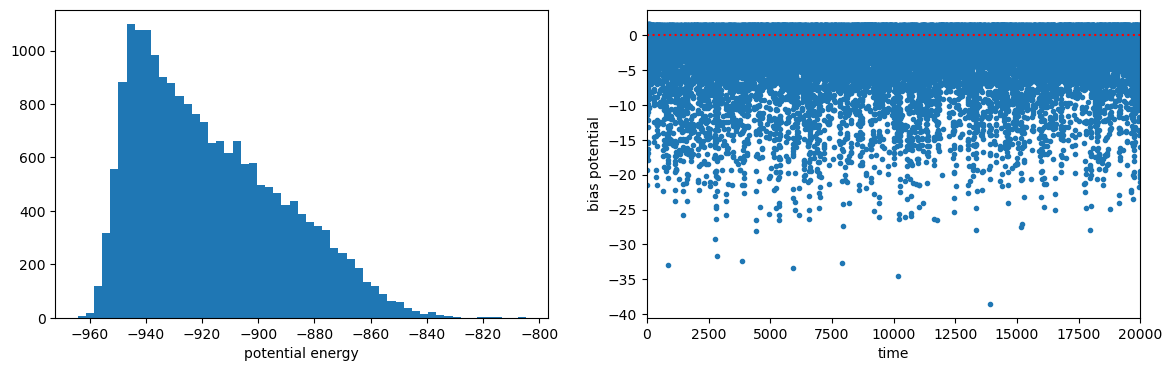

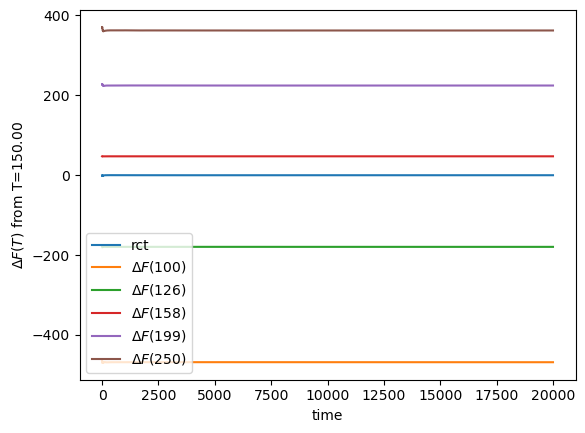

DeltaF_250-150: -290.635
DeltaF_250-100: -666.098


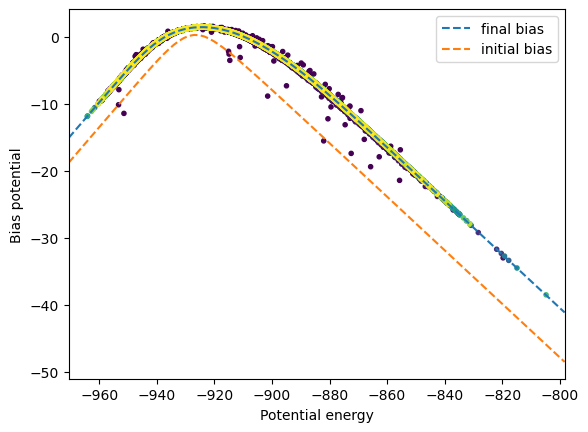

In [16]:
# more plotting
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(ener, bins='auto')
plt.xlabel('potential energy')

plt.subplot(1,2,2)
plt.plot(bias, '.')
plt.axhline(0, c='r', ls=':')
plt.xlim(0, len(bias))
plt.ylabel('bias potential')
plt.xlabel('time')
plt.show()

plt.plot(all_rct, label='rct')
for i in range(df_size):
    plt.plot(all_df[:,i], label=f'$\Delta F$({temperatures[i]:.0f})')
plt.xlabel('time')
plt.ylabel(f'$\Delta F(T)$ from T={temp:.2f}')
plt.legend()
plt.show()
print(f'DeltaF_{Tmax}-{temp}: {-beta*running_df[-1]:g}')
print(f'DeltaF_{Tmax}-{Tmin}: {beta*(running_df[0]-running_df[-1]):g}')

def biasFunc(u, df=running_df):
    return -1/beta*(np.logaddexp.reduce([beta*((1-temp/temperatures[k])*u+df[k]) for k in range(df_size)])-np.log(df_size))
plt.scatter(ener, bias, marker='.', c=range(len(bias)))
s = ener.std()/4
ener_range = np.linspace(min(ener)-s, max(ener)+s, 100)
plt.plot(ener_range, biasFunc(ener_range, df=all_df[-1,:]), ls='--', label='final bias')
plt.plot(ener_range, biasFunc(ener_range, df=all_df[0,:]), ls='--', label='initial bias')
plt.xlim(ener_range[[0,-1]])
plt.ylabel('Bias potential')
plt.xlabel('Potential energy')
plt.legend()
plt.show()

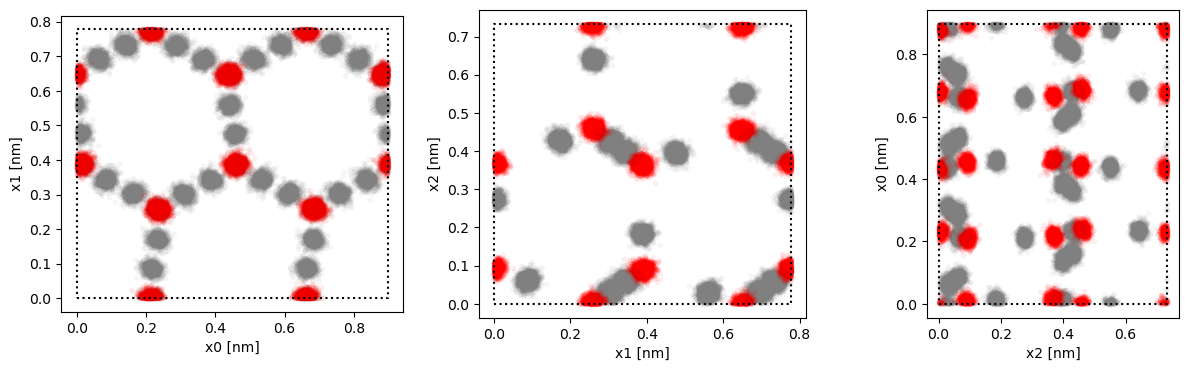

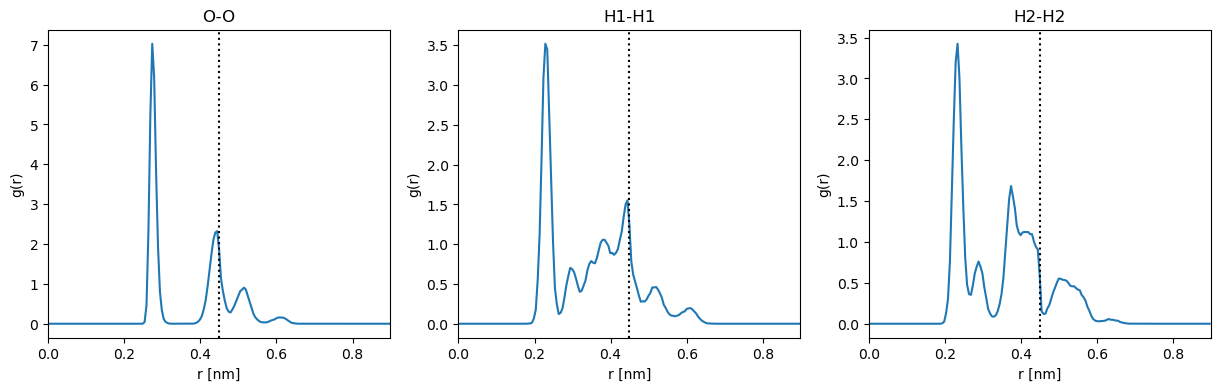

In [17]:
model.plot_2Dview(MDpos, MDbox, toPBC=toPBC)

#plot rdf
r_range = [0, model.box.max()]
names = ['O', 'H1', 'H2']
n = 1
plt.figure(figsize=(5*len(names), 4))
for a in names:
    plt.subplot(1, len(names), n)
    
    plt.title(f'{a}-{a}')
    model.plot_rdf(MDpos, r_range=r_range, selection=f'name == {a}')
    plt.axvline(model.box.max()/2, ls=':', c='k')
    n += 1   
plt.show()

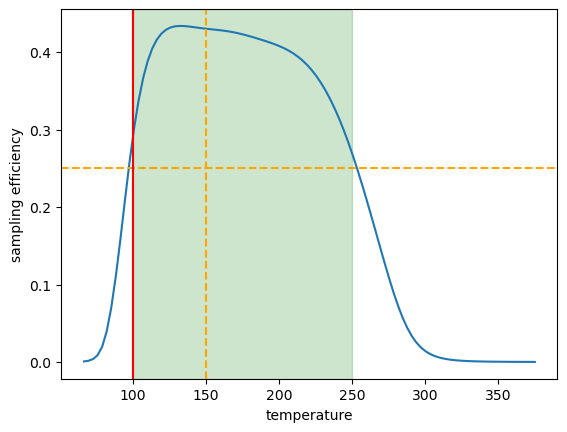

Sampling efficiency at 100K: 28.89%
 Effective sample size 100K: 5778.47


In [22]:
transient = 0# 5_000
myT = 100
mybias = bias[transient:]
myener = ener[transient:]

def sampling_efficiency(logw):
    return np.exp(2*np.logaddexp.reduce(logw)-np.logaddexp.reduce(2*logw))/len(logw)

temp_range = np.linspace(Tmin/1.5, Tmax*1.5, 100)
SEs = np.array([ sampling_efficiency(beta*((1-temp/t)*myener+mybias)) for t in temp_range])
plt.plot(temp_range, SEs)
plt.axhline(1/len(temperatures), ls='--', c='orange')
plt.axvspan(Tmin, Tmax, color='green', alpha=0.2)
plt.axvline(x=temp, ls='--', c='orange')
plt.axvline(x=myT, c='red')
plt.xlabel("temperature")
plt.ylabel("sampling efficiency")
plt.show()

logw = beta * ((1 - temp / myT) * myener + mybias)
print(f'Sampling efficiency at {myT}K: {sampling_efficiency(logw):.2%}')
print(f' Effective sample size {myT}K: {sampling_efficiency(logw)*len(logw):g}')


In [30]:
beta*(running_df[0]-running_df[-1])

666.0984226079247